# Research Track 1 - 2° assignment with jupyter integration

In [1]:
%matplotlib notebook
import sys
sys.path.append('/my_ros/src/RT_assignment_2')

import jupyros as jr
import rospy

import ipywidgets as widgets
from ipywidgets import Layout, HBox

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

import math
import time
import select
import actionlib
import actionlib.msg
from std_srvs.srv import *
from nav_msgs.msg import Odometry
from geometry_msgs.msg import Point, Pose, Twist
from sensor_msgs.msg import LaserScan
import RT_assignment_2.msg
from RT_assignment_2.msg import Pos

In [2]:
# Create widgets
goal_wdgt = widgets.Text(placeholder='x,y', layout=Layout(width='15%'))
goal_canc_btn = widgets.Button(description='Cancel goal', button_style='danger')
nearest_obst_wdgt = widgets.FloatText(description='Nearest obstacle')
robot_pos_wdgt = widgets.Text(description='Current position', layout=Layout(width='40%'))
canc_goals_wdgt = widgets.IntText(description='Goals canceled', value=0, layout=Layout(width='15%'))
set_goals_wdgt = widgets.IntText(description='Goals set', value=0, layout=Layout(width='15%'))

In [3]:
# Plots the positions of the robot
def plot(x_data, y_data):
    x_data_np = np.array(x_data)
    y_data_np = np.array(y_data)
    axs[0].plot(x_data_np, y_data_np, color='b')

In [4]:
# Plots the set/cancelled goals
def plot_goals(set_data, canc_data):
    axs[1].bar(['set', 'canc'], [set_data, canc_data], width=0.6, color=['g', 'r'])

In [5]:
# Odometry callback: send the current position and updates widgets and path plot
def callback(data):
    global robot_pos_wdgt, x_data, y_data, frame_count
    frame_count += 1
    # Get position and linear velocity from odometry
    position = data.pose.pose.position
    linear_velocity = data.twist.twist.linear
    # Create a message of type Pos
    msg = Pos()
    # Fill the message with the position and linear velocity
    msg.x = position.x
    msg.y = position.y
    msg.vx = linear_velocity.x
    msg.vy = linear_velocity.y

    # Set current position value
    if frame_count >= 10:
        robot_pos_wdgt.value = f'{msg.x:.6f},  {msg.y:.6f}'
        frame_count = 0

    x_data.append(msg.x)
    y_data.append(msg.y)

    # Publish the message
    pub.publish(msg)
    
    plot(x_data, y_data)

In [6]:
def get_nearest_obst(data):
    global nearest_obst_wdgt, frame_count_obst
    nearest_obst = min(data.ranges)
    frame_count_obst += 1
    if frame_count_obst >= 10:
        nearest_obst_wdgt.value = round(nearest_obst, 6)
        frame_count_obst = 0

In [7]:
def send_coords(wdgt):
    global set_goals, set_goals_wdgt, canc_goals
    if wdgt.value:
        set_goals += 1
        set_goals_wdgt.value = set_goals
        # Create a message of type PlanningGoal
        goal = RT_assignment_2.msg.PlanningGoal()
        # Fill the message with the goal coordinates
        goal.target_pose.pose.position.x = float(wdgt.value.split(',')[0])
        goal.target_pose.pose.position.y = float(wdgt.value.split(',')[1])
        
        plot_goals(set_goals, canc_goals)
        axs[0].scatter(goal.target_pose.pose.position.x, goal.target_pose.pose.position.y, marker='x', color='g')

        # Send the goal to the action server
        client.send_goal(goal)

In [13]:
def canc_goal(btn):
    global canc_goals, canc_goals_wdgt, set_goals, goal_wdgt
    canc_goals += 1
    canc_goals_wdgt.value = canc_goals
    plot_goals(set_goals, canc_goals)
    axs[0].scatter(float(goal_wdgt.value.split(',')[0]), float(goal_wdgt.value.split(',')[1]), marker='x', color='r')
    client.cancel_goal()

In [9]:
print("Insert the goal coordinates (x,y), then press ENTER:")

goal_box = HBox([goal_wdgt, goal_canc_btn])
display(goal_box, nearest_obst_wdgt, robot_pos_wdgt, set_goals_wdgt, canc_goals_wdgt)

goal_wdgt.on_submit(send_coords)
goal_canc_btn.on_click(canc_goal)

Insert the goal coordinates (x,y), then press ENTER:


FloatText(value=0.0, description='Nearest obstacle')

Text(value='', description='Current position', layout=Layout(width='40%'))

IntText(value=0, description='Goals set', layout=Layout(width='15%'))

IntText(value=0, description='Goals canceled', layout=Layout(width='15%'))

<IPython.core.display.Javascript object>


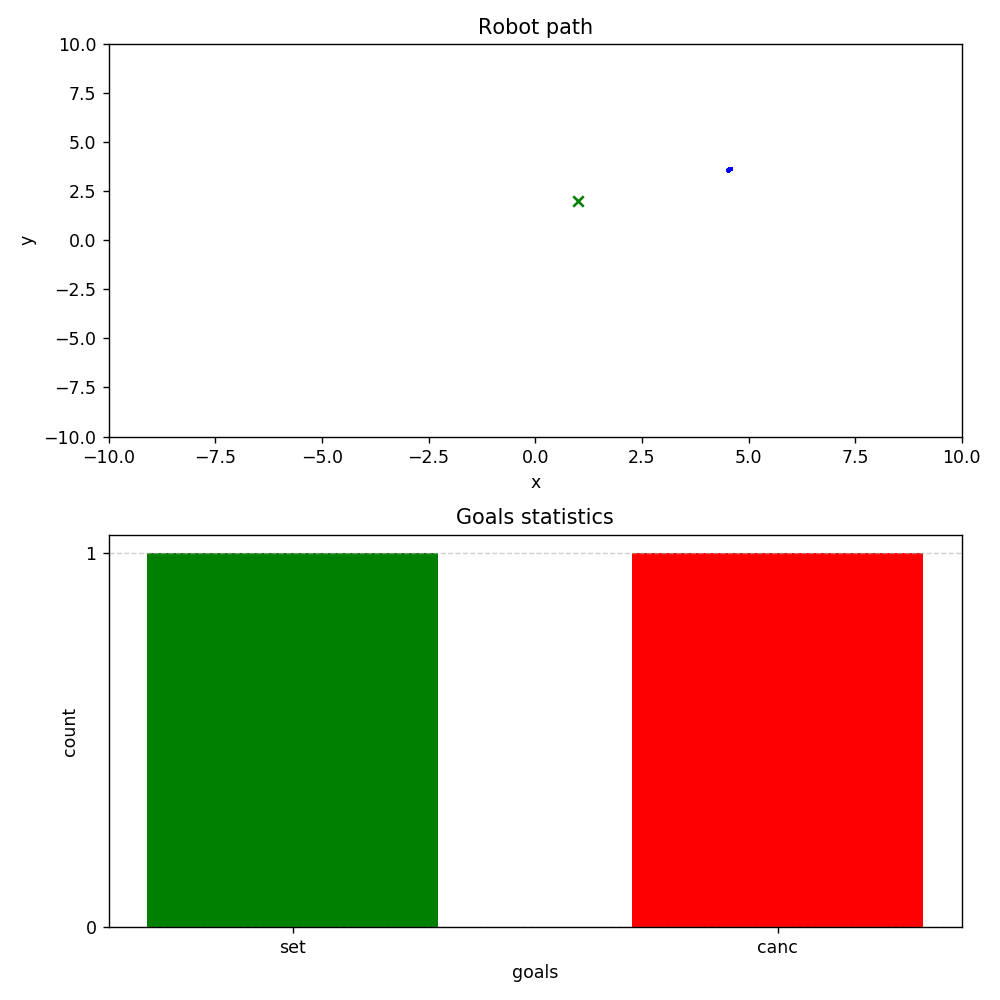

In [10]:
# Counters
canc_goals = 0
set_goals = 0
frame_count = 0
frame_count_obst = 0

# Array of robot positions
x_data, y_data = [], []

# Current goal
x_goal, y_goal = 0, 0

# Initialize the node
rospy.init_node('client')

# Publisher for the position of the robot
pub = rospy.Publisher('/pos', Pos, queue_size=1)

# Initialize the action client
client = actionlib.SimpleActionClient('/reaching_goal', RT_assignment_2.msg.PlanningAction)
# Wait for the action server to start
client.wait_for_server()

# Set the plots
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Robot's path plot settings
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(-10, 10)
axs[0].set_title('Robot path')
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

# Goals plot settings
axs[1].grid(axis='y', linestyle='--', alpha=0.6)
axs[1].set_yticks(range(0, 11, 1))
axs[1].set_title('Goals statistics')
axs[1].set_xlabel('goals')
axs[1].set_ylabel('count')

# Draw plots
x_data_np = np.array(x_data)
y_data_np = np.array(y_data)
axs[0].plot(x_data_np, y_data_np)

axs[1].bar(['set', 'canc'], [set_goals, canc_goals], width=0.5, color=['g', 'r'])

# Adjust the layout of the subplots
plt.tight_layout()

In [11]:
# Subscriber to the odometry of the robot to get the position and velocity
odom = rospy.Subscriber('/odom', Odometry, callback)

In [12]:
# Get nearest obstacle
obst_scan = rospy.Subscriber('/scan', LaserScan, get_nearest_obst)